# 6103 Tean project

## Drouvas Panagiotis, Dimos Giorgos, Kontoudakis Nikos, Vergas Panagiotis

In [20]:
#library import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Part 1.

In [21]:
# specifically for part 1
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#future selection
from sklearn.feature_selection import mutual_info_classif

In [22]:
#insert the data

# the names might be icorect
collumnNames =  [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", 
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", 
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", 
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", 
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", 
    "dst_host_srv_rerror_rate", "label"
]

allData =pd.read_csv('kddcup.data_10_percent', header=None, names = collumnNames)
y_labels = allData.iloc[:, -1]

In [23]:
# one hot encoding
data = pd.get_dummies(allData.iloc[:, 0:41], columns=["protocol_type", "service", "flag"])

# normalize
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# reduce dimensions
pca = PCA(n_components=14)
data = pca.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(data, y_labels, test_size=0.85, random_state=13)

In [24]:
information=mutual_info_classif(X_train,y_train)
print('Information=',information)

Information= [1.03241879 1.02287083 0.97694346 0.99973126 0.91945711 0.91934537
 0.90161707 0.94274191 0.90634923 0.88494754 0.81531941 0.82259571
 0.84932376 0.83953472]


## DBSCAN

### loop to find best hyper paramters (I bear no responsibility for burned CPUs)

In [ ]:
evaluationMetricsDBSCAN = []
data = X_train.copy()
print(len(data))
for i in np.arange(4, 10, 2):
    for x in [ 0.2, 0.5, 1, 2]:  
        db = DBSCAN(eps=x, min_samples=i).fit(data)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        if(len(set(labels))> 1 and n_clusters_ > 1):
            silhouette_values = silhouette_samples(data, labels)
          
            # print ('silhouette=', np.mean(silhouette_values))
            # print('Estimated number of clusters: %d' % n_clusters_)
            # print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data, labels))

            evaluationMetricsDBSCAN.append({'min_samples': i, 'eps': x, 'silhouette': round(np.mean(silhouette_values), 3), 'expected number of clusters': n_clusters_})
        # else:
            # print("no results for:", len(set(labels)),  n_clusters_)
            

In [29]:
metricsDF = pd.DataFrame(evaluationMetricsDBSCAN)
sortedMetrics= metricsDF.sort_values(by=['silhouette'], ascending= False)
print(sortedMetrics[:4])
sortedMetrics= sortedMetrics.sort_values(by=['expected number of clusters'], ascending= True)
print(sortedMetrics[:4])

   min_samples  eps  silhouette  expected number of clusters
7            8  0.5       0.865                           38
4            6  0.5       0.859                           44
1            4  0.5       0.850                           49
6            8  0.2       0.833                           70
   min_samples  eps  silhouette  expected number of clusters
8            8  1.0       0.766                            7
2            4  1.0       0.510                            7
5            6  1.0       0.753                            8
7            8  0.5       0.865                           38


In [31]:
# once more with the best parameters ( i choose something with few clusters)
db = DBSCAN(eps=1, min_samples=8).fit(data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

### Ploting

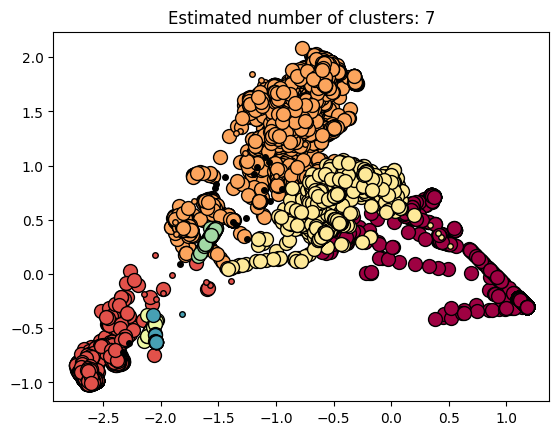

In [32]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
plt.figure('dbscan')

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    # core nodes
    xy = data[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    # border nodes
    xy = data[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=4)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()
# black is noise.

### dimension reduction (better ploting)

In [33]:
# Compute silhouette score
if len(set(labels)) > 1:
    silhouette_values = silhouette_samples(data, labels)
    print('Silhouette: ', round(np.mean(silhouette_values), 3))
else:
    print("Silhouette score not applicable (only one cluster detected)")

core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
            
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters: {n_clusters_}")

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)

Silhouette:  0.766
Number of clusters: 7


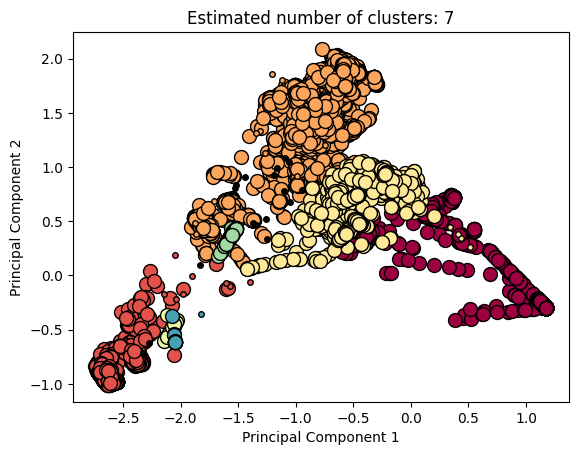

In [34]:
plt.figure('pca-dbscan')
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise

    class_member_mask = (labels == k)

    # Core points
    xy = data_2d[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    # Border points
    xy = data_2d[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=4)

plt.title(f'Estimated number of clusters: {n_clusters_}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()